In [19]:
# ==========================
# Hand2Math Custom Dataset Training
# ==========================

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [20]:
# --------------------------
# 1. Preprocessing Function
# --------------------------
def preprocess_symbol(path):
    """Load image, normalize to MNIST style (white symbol on black, 28x28)."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Invert if background is white
    if np.mean(img) > 127:
        img = 255 - img

    # Threshold (binarize)
    _, img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

    # Find bounding box
    coords = cv2.findNonZero(img)
    if coords is None:   # skip empty images
        return None
    x, y, w, h = cv2.boundingRect(coords)
    img = img[y:y+h, x:x+w]

    # Resize to 20x20
    img = cv2.resize(img, (20,20), interpolation=cv2.INTER_AREA)

    # Pad to 28x28
    padded = np.zeros((28,28), dtype=np.uint8)
    x_offset = (28 - 20) // 2
    y_offset = (28 - 20) // 2
    padded[y_offset:y_offset+20, x_offset:x_offset+20] = img

    # Normalize
    padded = padded.astype("float32") / 255.0
    return np.expand_dims(padded, -1)


In [21]:
# --------------------------
# 2. Map Labels
# --------------------------
class_map = {
    "0": 0, "1": 1, "2": 2, "3": 3, "4": 4,
    "5": 5, "6": 6, "7": 7, "8": 8, "9": 9,
    "add": 10,
    "sub": 11,
    "mul": 12,
    "div": 13,
    "equal": 14,
    "dec": 15   # decimal point
}


In [22]:
# --------------------------
# 3. Load Dataset
# --------------------------
base_path = "./datasets"
imgs, labels = [], []

for folder, label in class_map.items():
    path = os.path.join(base_path, folder)
    if not os.path.exists(path):
        continue
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        arr = preprocess_symbol(file_path)
        if arr is not None:
            imgs.append(arr)
            labels.append(label)

X = np.array(imgs)
y = np.array(labels)

print("Dataset shape:", X.shape, y.shape)


Dataset shape: (9008, 28, 28, 1) (9008,)


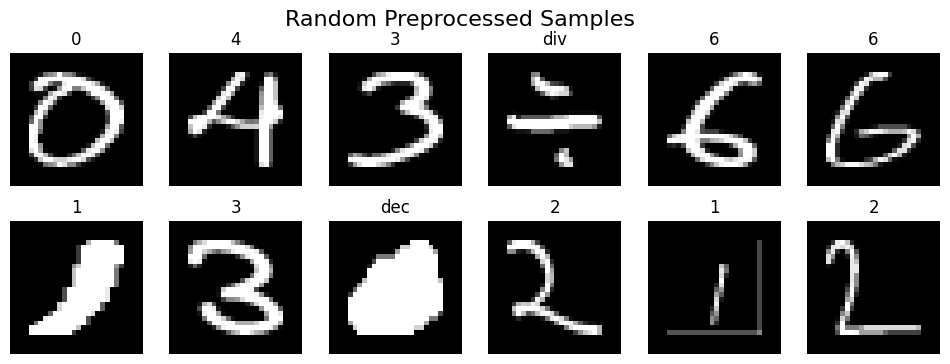

In [23]:
# --------------------------
# 3.5 Visualize Preprocessed Samples
# --------------------------
plt.figure(figsize=(12,4))
for i in range(12):
    idx = np.random.randint(0, len(X))
    plt.subplot(2,6,i+1)
    plt.imshow(X[idx].reshape(28,28), cmap="gray")
    plt.title(list(class_map.keys())[list(class_map.values()).index(y[idx])])
    plt.axis("off")
plt.suptitle("Random Preprocessed Samples", fontsize=16)
plt.show()


In [24]:
# --------------------------
# 4. Train/Test Split
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Val set:", X_val.shape, y_val.shape)


Train set: (8107, 28, 28, 1) (8107,)
Val set: (901, 28, 28, 1) (901,)


In [25]:
# --------------------------
# 5. Build CNN
# --------------------------
num_classes = len(class_map)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


/home/tathagat/Hand2Math/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,808 (882.06 KB)

 Trainable params: 225,808 (882.06 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# --------------------------
# 6. Train Model
# --------------------------
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val)
)


Epoch 1/15
115/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4273 - loss: 1.8226

2025-09-17 00:42:34.032382: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-17 00:42:34.239851: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_630', 4 bytes spill stores, 4 bytes spill loads

2025-09-17 00:42:34.862031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_856', 132 bytes spill stores, 132 bytes spill loads

2025-09-17 00:42:34.999327: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_856', 272 byte

127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6324 - loss: 1.1868 - val_accuracy: 0.8835 - val_loss: 0.3918
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8527 - loss: 0.4783 - val_accuracy: 0.9345 - val_loss: 0.2423
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9053 - loss: 0.3194 - val_accuracy: 0.9523 - val_loss: 0.1695
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9238 - loss: 0.2479 - val_accuracy: 0.9567 - val_loss: 0.1416
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9359 - loss: 0.2059 - val_accuracy: 0.9678 - val_loss: 0.1199
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9419 - loss: 0.1819 - val_accuracy: 0.9711 - val_loss: 0.1015
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9508 - loss: 0.1527 - val_accuracy: 0.9756 - val_loss: 0.0905
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9563 - loss: 0.1423 - val_accuracy: 0.9723 - val

In [27]:
# --------------------------
# 7. Save Model
# --------------------------
model.save("hand2math_custom_cnn.keras")
print("✅ Model saved as hand2math_custom_cnn.keras")


✅ Model saved as hand2math_custom_cnn.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


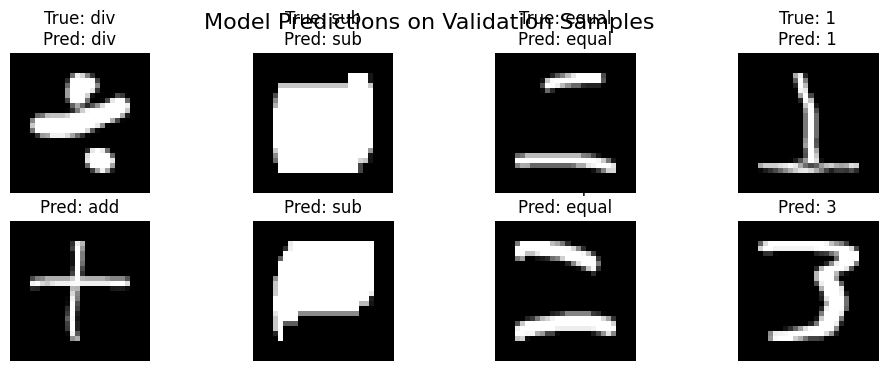

In [28]:
import random

# Mapping back from numeric label → class name
inv_class_map = {v:k for k,v in class_map.items()}

plt.figure(figsize=(12,4))
for i in range(8):  # show 8 random samples
    idx = random.randint(0, len(X_val)-1)
    img = X_val[idx]
    true_label = inv_class_map[y_val[idx]]

    # Predict
    pred = model.predict(img.reshape(1,28,28,1))
    pred_label = inv_class_map[np.argmax(pred)]

    # Plot
    plt.subplot(2,4,i+1)
    plt.imshow(img.reshape(28,28), cmap="gray")
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.suptitle("Model Predictions on Validation Samples", fontsize=16)
plt.show()


In [31]:
path = "test1.png"
img = preprocess_symbol(path)  # use same preprocessing function
pred = model.predict(img.reshape(1,28,28,1))
print("Predicted:", inv_class_map[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: mul


In [32]:
def predict_equation(image_path, model, class_map):
    # Load grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")

    # Invert if background is white
    if np.mean(img) > 127:
        img = 255 - img

    # Threshold
    _, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

    # Find contours (symbols)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    symbol_images = []
    boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w*h < 50:   # skip tiny noise
            continue
        roi = thresh[y:y+h, x:x+w]

        # Resize like MNIST
        roi = cv2.resize(roi, (20,20), interpolation=cv2.INTER_AREA)
        padded = np.zeros((28,28), dtype=np.uint8)
        x_offset = (28 - 20) // 2
        y_offset = (28 - 20) // 2
        padded[y_offset:y_offset+20, x_offset:x_offset+20] = roi
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, -1)

        symbol_images.append(padded)
        boxes.append((x,y,w,h))

    # Sort symbols left→right by x coordinate
    symbols_sorted = [s for _,s in sorted(zip(boxes, symbol_images), key=lambda b: b[0][0])]

    # Predict each symbol
    inv_class_map = {v:k for k,v in class_map.items()}
    expression = ""
    for s in symbols_sorted:
        pred = model.predict(s.reshape(1,28,28,1), verbose=0)
        label = inv_class_map[np.argmax(pred)]
        if label == "add":
            expression += "+"
        elif label == "sub":
            expression += "-"
        elif label == "mul":
            expression += "*"
        elif label == "div":
            expression += "/"
        elif label == "equal":
            expression += "="
        elif label == "dec":
            expression += "."
        else:
            expression += label

    return expression


In [33]:
equation = predict_equation("test3.png", model, class_map)
print("Detected:", equation)

# Optionally evaluate (safely)
try:
    if "=" in equation:
        lhs, rhs = equation.split("=")
        print(f"{lhs} = {eval(lhs)} | RHS: {rhs}")
    else:
        result = eval(equation)
        print("Result:", result)
except Exception as e:
    print("⚠️ Could not evaluate:", e)


Detected: 2+2
Result: 4


In [34]:
equation = predict_equation("test4.png", model, class_map)
print("Detected:", equation)

# Optionally evaluate (safely)
try:
    if "=" in equation:
        lhs, rhs = equation.split("=")
        print(f"{lhs} = {eval(lhs)} | RHS: {rhs}")
    else:
        result = eval(equation)
        print("Result:", result)
except Exception as e:
    print("⚠️ Could not evaluate:", e)


Detected: 3*7*3
Result: 63


In [35]:
equation = predict_equation("test5.png", model, class_map)
print("Detected:", equation)

# Optionally evaluate (safely)
try:
    if "=" in equation:
        lhs, rhs = equation.split("=")
        print(f"{lhs} = {eval(lhs)} | RHS: {rhs}")
    else:
        result = eval(equation)
        print("Result:", result)
except Exception as e:
    print("⚠️ Could not evaluate:", e)


Detected: 5+3*7
Result: 26


In [36]:
equation = predict_equation("test6.png", model, class_map)
print("Detected:", equation)

# Optionally evaluate (safely)
try:
    if "=" in equation:
        lhs, rhs = equation.split("=")
        print(f"{lhs} = {eval(lhs)} | RHS: {rhs}")
    else:
        result = eval(equation)
        print("Result:", result)
except Exception as e:
    print("⚠️ Could not evaluate:", e)


Detected: 7+3
Result: 10
